データについて正規化を行い、三つのモデルに精度に応じた重みを付けてブレンディング
DT、LightGBM、XGBoostを使用。

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import sklearn.metrics
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import robust_scale # 一次元配列はこれで直接。二次元配列はRobustScalerを使うことが多い
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import seaborn as sns

import collections
import time

import lightgbm as lgb
import optuna

from xgboost import XGBClassifier

Duplicate key in file WindowsPath('C:/Users/GuestUser/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family:  IPAexGothic')


In [2]:
pd.set_option('display.max_rows', None)

データを変数に入れる

In [3]:
train = pd.read_table('train.tsv')
test = pd.read_csv('test.tsv',sep='\t')
sample = pd.read_csv('sample_submit.csv',header=None)

データを見る・データを整える

In [4]:
train = train.replace({"Y":{"<=50K" : 0, ">50K" : 1}})
train["Y"].value_counts()

0    12288
1     3992
Name: Y, dtype: int64

In [5]:
trainX = train.iloc[:,0:15]
y = train["Y"]
testX = test.copy()

In [6]:
# education = education-num より消去
train = train.drop(columns=["id","education"])
trainX = trainX.drop(columns=["id","education"])
testX = testX.drop(columns=["id","education"])

In [7]:
# native-countryについて、trainかtest片方にしかないものは？に変換してしまう。
indexNum = testX[~testX["native-country"].isin(trainX["native-country"].unique())].index
for i in indexNum:
    testX.iat[i,12] = "?"
    print(testX.iat[i,12])

?


In [8]:
# sexを数値化
trainX = trainX.replace({"sex":{"Female" : 0, "Male" : 1}})
testX = testX.replace({"sex":{"Female" : 0, "Male" : 1}})

In [11]:
trainX.describe()

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week
count,16280.000000,1.628000e+04,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000
mean,38.603808,1.899753e+05,10.089558,0.665602,1131.057617,88.075369,40.410012
std,13.672102,1.048903e+05,2.570911,0.471794,7672.406043,405.251482,12.311716
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,0.000000,1.000000
25%,28.000000,1.186912e+05,9.000000,0.000000,0.000000,0.000000,40.000000
50%,37.000000,1.789955e+05,10.000000,1.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376340e+05,12.000000,1.000000,0.000000,0.000000,45.000000
max,90.000000,1.226583e+06,16.000000,1.000000,99999.000000,4356.000000,99.000000


In [12]:
testX.describe()

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week
count,16281.000000,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000
mean,38.559487,1.895814e+05,10.071801,0.672809,1024.243351,86.532338,40.464898
std,13.609075,1.062084e+05,2.574576,0.469202,7086.407756,400.666956,12.383353
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,0.000000,1.000000
25%,28.000000,1.173630e+05,9.000000,0.000000,0.000000,0.000000,40.000000
50%,37.000000,1.776330e+05,10.000000,1.000000,0.000000,0.000000,40.000000
75%,48.000000,2.366870e+05,12.000000,1.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,1.000000,99999.000000,4356.000000,99.000000


In [13]:
pd.reset_option('display.max_rows')

In [14]:
trainX["fnlwgt"].value_counts()

123983    8
203488    8
174789    8
99185     8
138768    8
         ..
80430     1
237078    1
268451    1
82488     1
303674    1
Name: fnlwgt, Length: 12870, dtype: int64

<AxesSubplot:ylabel='Frequency'>

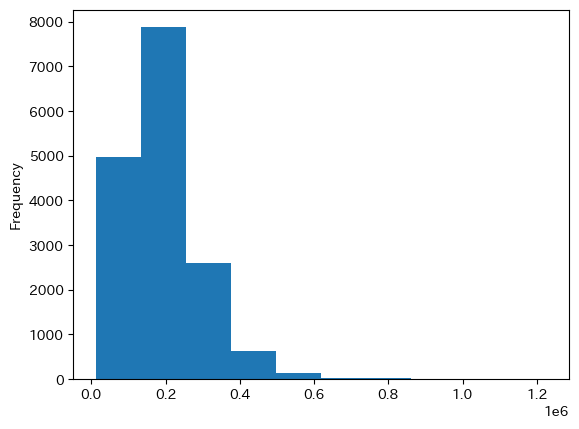

In [15]:
trainX["fnlwgt"].plot.hist()

データの正規化（変な外れ値のなさそうな'age', 'education-num'）・robust（最大最小で2桁以上異なり外れ値もありそうな'fnlwgt'）

In [16]:
minmax_scaler = preprocessing.MinMaxScaler() # 二次元配列のもののみ（一次元配列：minmax_scale(対象となる配列))

trainX[['age', 'education-num']] = minmax_scaler.fit_transform(trainX[['age', 'education-num']]) 
testX[['age', 'education-num']] = minmax_scaler.fit_transform(testX[['age', 'education-num']]) 
trainX['fnlwgt'] = robust_scale(trainX['fnlwgt'])
testX['fnlwgt'] = robust_scale(testX['fnlwgt']) 

In [17]:
trainX['fnlwgt'].describe()

count    16280.000000
mean         0.092312
std          0.881855
min         -1.401603
25%         -0.507002
50%          0.000000
75%          0.492998
max          8.807494
Name: fnlwgt, dtype: float64

3モデルを作る

In [19]:
trainX = pd.get_dummies(trainX)
testX = pd.get_dummies(testX)

In [20]:
trainX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 90 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   age                                        16280 non-null  float64
 1   fnlwgt                                     16280 non-null  float64
 2   education-num                              16280 non-null  float64
 3   sex                                        16280 non-null  int64  
 4   capital-gain                               16280 non-null  int64  
 5   capital-loss                               16280 non-null  int64  
 6   hours-per-week                             16280 non-null  int64  
 7   workclass_?                                16280 non-null  uint8  
 8   workclass_Federal-gov                      16280 non-null  uint8  
 9   workclass_Local-gov                        16280 non-null  uint8  
 10  workclass_Never-worked

In [23]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(trainX, y, test_size=0.2, random_state = 100)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state = 100)
print(trainX.shape, X_train.shape, X_valid.shape, X_test.shape)

(16280, 90) (10419, 90) (2605, 90) (3256, 90)


3モデルを作る

In [24]:
model_DT = DT()

model_LGB = lgb.LGBMClassifier(boosting_type='goss', max_depth=6, random_state=0)

model_XGB10 = XGBClassifier(early_stopping_rounds=10)
model_XGB15 = XGBClassifier(early_stopping_rounds=15)

In [25]:
model_DT.fit(X_train, y_train)

tests = [(X_test, y_test)]
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=15))
callbacks.append(lgb.log_evaluation())

model_LGB.fit(X_train, y_train, eval_set=tests, callbacks=callbacks)

model_XGB10.fit(X_train, y_train, eval_set=tests, verbose=True)
model_XGB15.fit(X_train, y_train, eval_set=tests, verbose=True)

[1]	valid_0's binary_logloss: 0.511795
Training until validation scores don't improve for 15 rounds
[2]	valid_0's binary_logloss: 0.481821
[3]	valid_0's binary_logloss: 0.458024
[4]	valid_0's binary_logloss: 0.438747
[5]	valid_0's binary_logloss: 0.422328
[6]	valid_0's binary_logloss: 0.408078
[7]	valid_0's binary_logloss: 0.396088
[8]	valid_0's binary_logloss: 0.385551
[9]	valid_0's binary_logloss: 0.376185
[10]	valid_0's binary_logloss: 0.36848
[11]	valid_0's binary_logloss: 0.361077
[12]	valid_0's binary_logloss: 0.355859
[13]	valid_0's binary_logloss: 0.350556
[14]	valid_0's binary_logloss: 0.346252
[15]	valid_0's binary_logloss: 0.341767
[16]	valid_0's binary_logloss: 0.338374
[17]	valid_0's binary_logloss: 0.335306
[18]	valid_0's binary_logloss: 0.332723
[19]	valid_0's binary_logloss: 0.330275
[20]	valid_0's binary_logloss: 0.327873
[21]	valid_0's binary_logloss: 0.326079
[22]	valid_0's binary_logloss: 0.324424
[23]	valid_0's binary_logloss: 0.322592
[24]	valid_0's binary_logloss

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=15,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

各モデルの精度を見る。
モデルごとの正答率を学習用と検証用データの双方について算出

In [26]:
names = ["DT", "LGB", "XGB10", "XGB15"]

classifiers = [
    model_DT,
    model_LGB,
    model_XGB10,
    model_XGB15,
    ]

result = []

for name, clf in zip(names, classifiers):
    score1 = clf.score(X_train, y_train) # 正解率（train）の算出
    score2 = clf.score(X_test, y_test) # 正解率（test）の算出
    result.append([score1, score2]) # 結果の格納

In [27]:
df_result = pd.DataFrame(result, columns=['train', 'test'], index=names).sort_values('test', ascending=False)
df_result

,train,test
XGB10,0.896919,0.861794
XGB15,0.896919,0.861794
LGB,0.887129,0.858108
DT,1.000000,0.816646


In [28]:
test_pred_DT = model_DT.predict(X_test)
test_pred_LGB = model_LGB.predict(X_test)
test_pred_XGB10 = model_XGB10.predict(X_test)
test_pred_XGB15 = model_XGB15.predict(X_test)

In [29]:
from sklearn.metrics import mean_squared_error
print ("モデル1の平均2乗誤差: {:.4f}".format(mean_squared_error(y_test, test_pred_DT)))
print ("モデル2の平均2乗誤差: {:.4f}".format(mean_squared_error(y_test, test_pred_LGB)))
print ("モデル3の平均2乗誤差: {:.4f}".format(mean_squared_error(y_test, test_pred_XGB10)))
print ("モデル3の平均2乗誤差: {:.4f}".format(mean_squared_error(y_test, test_pred_XGB15)))

モデル1の平均2乗誤差: 0.1834
モデル2の平均2乗誤差: 0.1419
モデル3の平均2乗誤差: 0.1382
モデル3の平均2乗誤差: 0.1382


XGBはearly_stopping_roundsを変えても精度は同じだった。  
検証用データにおける精度はXGB＞LGB＞DT

スタッキング（ブレンディング）

In [30]:
first_pred_DT = model_DT.predict(X_valid)
first_pred_LGB = model_LGB.predict(X_valid)
first_pred_XGB10 = model_XGB10.predict(X_valid)
first_pred_XGB15 = model_XGB15.predict(X_valid)

In [31]:
stack_pred = np.column_stack((first_pred_DT, first_pred_LGB, first_pred_XGB10, first_pred_XGB15))
stack_pred

array([[0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 1, 1],
       ...,
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int64)

In [32]:
# 各モデルの検証データを積み重ねる
stack_test_pred = np.column_stack((test_pred_DT, test_pred_LGB, test_pred_XGB10, test_pred_XGB15))

In [33]:
# メタモデルの学習 
meta_model1 = XGBClassifier(early_stopping_rounds=20)
eval_set2 = [(stack_test_pred, y_test)]
meta_model1.fit(stack_pred, y_valid, eval_set = eval_set2, verbose=True)

[0]	validation_0-logloss:0.54778
[1]	validation_0-logloss:0.47133
[2]	validation_0-logloss:0.42780
[3]	validation_0-logloss:0.40235
[4]	validation_0-logloss:0.38754
[5]	validation_0-logloss:0.37909
[6]	validation_0-logloss:0.37443
[7]	validation_0-logloss:0.37199
[8]	validation_0-logloss:0.37077
[9]	validation_0-logloss:0.37023
[10]	validation_0-logloss:0.37002
[11]	validation_0-logloss:0.36998
[12]	validation_0-logloss:0.37001
[13]	validation_0-logloss:0.37005
[14]	validation_0-logloss:0.37010
[15]	validation_0-logloss:0.37014
[16]	validation_0-logloss:0.37018
[17]	validation_0-logloss:0.37020
[18]	validation_0-logloss:0.37022
[19]	validation_0-logloss:0.37024
[20]	validation_0-logloss:0.37025
[21]	validation_0-logloss:0.37025
[22]	validation_0-logloss:0.37026
[23]	validation_0-logloss:0.37026
[24]	validation_0-logloss:0.37027
[25]	validation_0-logloss:0.37027
[26]	validation_0-logloss:0.37027
[27]	validation_0-logloss:0.37027
[28]	validation_0-logloss:0.37027
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [34]:
meta1_test_pred = meta_model1.predict(stack_test_pred)
print ("メタモデルの平均2乗誤差: {:.4f}".format(mean_squared_error(y_test, meta1_test_pred)))

メタモデルの平均2乗誤差: 0.1404


予測に代入して結果を出力する

In [35]:
production_pred_DT = model_DT.predict(testX)
production_pred_LGB = model_LGB.predict(testX)
production_pred_XGB10 = model_XGB10.predict(testX)
production_pred_XGB15 = model_XGB15.predict(testX)

In [36]:
stack_production_pred = np.column_stack((production_pred_DT, production_pred_LGB, production_pred_XGB10, production_pred_XGB15))
pred = meta_model1.predict(stack_production_pred)
pred_r = pd.DataFrame(data=pred, index=None, columns=None)
pred_r.value_counts()

0    13127
1     3154
dtype: int64

In [37]:
pred_r = pred_r.replace({0:{0 : "<=50K", 1 : ">50K"}})

In [38]:
sample[1] = pred_r

In [39]:
sample.to_csv("submit8_1.csv",index=None,header=None)